# MountainCar-v0 - Exercise

The Mountain Car problem is described as follows: a car is on a one-dimensional track, positioned between two mountains. The goal is to drive up the mountain on the right; however, the car’s engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

## 1. State space

The car’s state, at any point in time, is given by a vector containing its horizontal position and velocity. The car commences each episode stationary, at the bottom of the valley between the hills (at position approximately -0.5), and the episode ends when either the car reaches the flag (position  0.6) or after 200 moves.

<img src="./resources/mountaincar.png" style="height: 250px"/>

We can load the game environment and render what it looks like.

In [1]:
import gymnasium as gym


env = gym.make('MountainCar-v0', render_mode="human") # load the game environment
state, info = env.reset()

env.render() # visualize the environment - we only need to render it once - the rendering will be automatically updated




The environment opens in a different window. The environment is rendered, but the window is created via pygame, which is notorious for its 'Not Responding' windows. 
Especially after you try to interact with it, like dragging it to another position on your screen...

To close a (non-responsive) window, you can use the env.close()-command. But be warned: this also clears some other variables of the view, so you might run into trouble of you want to render it again. Best to restart your kernel after you've closed an environment...

In [2]:
# Use with caution: 

env.close()

Or, maybe a better way of doing things: drag your window where you want it, and reset the environment. This will bring your pygame window back to an 'active' state...

In [3]:
state, info = env.reset()

Now we can ask the car's state and print it.

In [4]:
print("State Space: {}\n".format(env.state))
print("Position: %f " % env.state[0])
print("Velocity: %f " % env.state[1])

State Space: [-0.48277802  0.        ]

Position: -0.482778 
Velocity: 0.000000 


As you can see, the state is a vector containing its horizontal position and velocity. Check in the figure if the car is indeed at the given horizontal position. The velocity should be zero. Right?

## 2. Reset the environment - Exercise

Try to reset the environment to a new random state, render it and print the state again. Do you see the car at a different location?

In [5]:
state, info = env.reset() # reset the environment to a new, random state
print("State Space: {}\n".format(env.state))

State Space: [-0.57187293  0.        ]



## 3. Action space

At each move, the car has three possible actions: push left (=0), push right (=2) or do nothing (=1), and a penalty of 1 unit is applied for each move taken (including doing nothing). This means that, unless the car can figure out a way to ascend the mountain in less than 200 moves, it will always achieve a total *reward* of -200 units.

The car performs an action by using the step-method:

```python
state, reward, done, truncated, info = env.step(action)
```

The episode will end after 200 moves (truncated). We will try to push the car to the right at each move and render the environment at each step. We will also count the number of steps and print it. As you can see, the car's engine is not strong enough to drive up the mountain.

In [6]:
state, info = env.reset()
i = 0
finished = False
while not finished:
    state, reward, done, truncated, info = env.step(2)
    i = i + 1
    finished = done or truncated

print("Steps: %d" % i)

Steps: 200


## 4. Random actions - Exercise

Maybe you can try to reach the flag by performing a random action at each step? Any success?

Steps: 200


## 5. Solving the environment without Reinforcement Learning - Exercise

Can you figure out a strategy to reach the flag within 200 moves? Try to code your strategy! Count the number of steps. My best try was reaching the flag in 89 steps. Can you do better?

Steps: 114


## 6. Solving the environment with Reinforcement Learning

So far, we have driven the car ourselves. This of course has nothing to do with Reinforcement Learning. The code below will use the Q-learning algorithm to let the agent use the environment's rewards to learn, over time, to take the best action to drive up the mountain. This code is just to demonstrate. This won't be an exam question.

We're making a new environment from scratch, because we don't want to render it for human consumption through our training of the Q-table. It would otherwise take way too long...

In [15]:
env.close()
# probably a good idea to restart your kernel after this one...

In [17]:
import gymnasium as gym
env = gym.make('MountainCar-v0') # load the game environment - with the default rendering mode of 'none'
state, info = env.reset()

env.render()

Warning: the code block below will run for a long time (10-15min), so the Q table is updated nicely. On average, it should take 170 steps (awards) or so. See below

In [19]:
import numpy as np
import matplotlib.pyplot as plt

state, info = env.reset()

# define Q-learning function
def QLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    #changed
    num_states = np.round(num_states, 0).astype(int) + 1
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        finished = False
        tot_reward, reward = 0,0
        state, info = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
    
        while finished != True:                  
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            state2, reward, done, truncated, info = env.step(action) 
            finished = done or truncated

            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            # Allow for terminal states
            if finished and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 1000 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 1000 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
                
    return Q, ave_reward_list

# run Q-learning algorithm
Q, rewards = QLearning(env, 0.35, 0.9, 0.8, 0, 100000)

Episode 1000 Average Reward: -200.0
Episode 2000 Average Reward: -200.0
Episode 3000 Average Reward: -200.0
Episode 4000 Average Reward: -200.0
Episode 5000 Average Reward: -200.0
Episode 6000 Average Reward: -200.0
Episode 7000 Average Reward: -200.0
Episode 8000 Average Reward: -199.995
Episode 9000 Average Reward: -200.0
Episode 10000 Average Reward: -200.0


Plotting the average reward vs the episode number after a lot of episodes, we can see that, initially, the average reward is fairly flat, with each run terminating once the maximum 200 movements is reached. This is the exploration phase of the algorithm. Only after a decent amount of episodes, the agent is making progress. This is because in Q learning, we need to update each posible action for each state. But here we have a big number of states (we had to make it the position and the velocity discrete), so it takes a lot of time...

Text(0.5, 1.0, 'Average Reward vs Episodes')

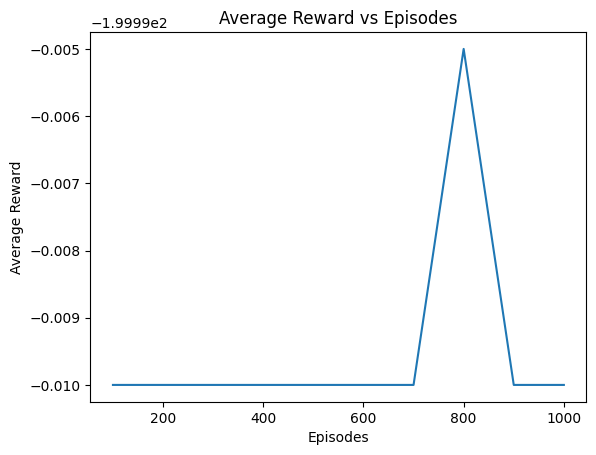

In [20]:
# plot rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

In [21]:
env = gym.make('MountainCar-v0', render_mode="human") # load the game environment
state, info = env.reset()
# Discretize state
state_adj = (state - env.observation_space.low)*np.array([10, 100])
state_adj = np.round(state_adj, 0).astype(int)

env.render()

state, info = env.reset()
i = 0
finished = False
while not finished:
    # Discretize state
    state_adj = (state - env.observation_space.low)*np.array([10, 100])
    state_adj = np.round(state_adj, 0).astype(int)
    action = np.argmax(Q[state_adj[0], state_adj[1]]) 
    state, reward, done, truncated, info = env.step(action)
    i = i + 1
    finished = done or truncated

print("Steps: %d" % i)


Steps: 200


Don't forget to close the environment.

In [22]:
env.close()